##Predicting Sarcasm using Word2Vec+LSTMs

In [13]:
#importing libraries
!pip install gensim
import numpy as np
import pandas as pd
import matplotlib as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

#using word2vec for word embeddings
import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import Word2Vec

nltk.download('punkt_tab')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0); random.seed(0)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
#loading datasets
train_df = pd.read_csv('train.csv')
print('train set has been loaded!')
train_df.name = 'train'
valid_df = pd.read_csv('valid.csv')
print('valid set has been loaded!')
valid_df.name = 'valid'
test_df = pd.read_csv('test.csv')
print('test set has been loaded!')
test_df.name = 'test'

train_labels = torch.tensor(
    train_df['label'].values,
    dtype=torch.float32
)
valid_labels = torch.tensor(
    valid_df['label'].values,
    dtype=torch.float32
)
test_labels = torch.tensor(
    valid_df['label'].values,
    dtype=torch.float32
)


train set has been loaded!
valid set has been loaded!
test set has been loaded!


In [15]:
#looking at features of train_df, valid_df, and test_df:
def features(df):
  print(f"Dataset: {df.name}")
  print(f"Size: {df.shape}")
  print(f"Columns: {df.columns}")
  print(f"Null Values: {df.isnull().sum()}")
  print(f"Head: {df.head()}\n")
  print(f"Description:\n{df.describe()}\n")

  #longest phrase in dataset
  max_len = 0
  max_len_phrase = ""
  for i in range(len(df)):
    if len(df['text'][i]) > max_len:
      max_len = len(df['text'][i])
      max_len_phrase = df['text'][i]
  print(f"Longest Phrase in Dataset: \n{max_len_phrase}, \nchar length {max_len}")

  #count of sarcasm vs non-sarcasm
  sarcasm_count = df['label'].value_counts()[1]
  non_sarcasm_count = df['label'].value_counts()[0]
  print(f"Sarcasm Count: {sarcasm_count}")
  print(f"Non-Sarcasm Count: {non_sarcasm_count}")
  print("-----------------------------")

features(train_df)
features(valid_df)
features(test_df)

Dataset: train
Size: (21464, 2)
Columns: Index(['text', 'label'], dtype='object')
Null Values: text     0
label    0
dtype: int64
Head:                                                 text  label
0  states slow to shut down weak teacher educatio...      0
1    drone places fresh kill on steps of white house      1
2  report: majority of instances of people gettin...      1
3  sole remaining lung filled with rich, satisfyi...      1
4                       the gop's stockholm syndrome      0

Description:
              label
count  21464.000000
mean       0.475960
std        0.499433
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Longest Phrase in Dataset: 
hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis bal

Based on the information above, there does not seem to be any null values in any of the datasets.

In [16]:
#extract text from sarcasm labels
train_text = train_df['text']
valid_text = valid_df['text']
test_text = test_df['text']

#tokenizing them
def tokenize(series):
    data = []
    for text in series:
        tokens = [w.lower() for w in word_tokenize(text)]
        data.append(tokens)
    return data


train_tokens = tokenize(train_text)
print(train_tokens)
valid_tokens = tokenize(valid_text)
test_tokens = tokenize(test_text)

[['states', 'slow', 'to', 'shut', 'down', 'weak', 'teacher', 'education', 'programs'], ['drone', 'places', 'fresh', 'kill', 'on', 'steps', 'of', 'white', 'house'], ['report', ':', 'majority', 'of', 'instances', 'of', 'people', 'getting', 'lives', 'back', 'on', 'track', 'occur', 'immediately', 'after', 'visit', 'to', 'buffalo', 'wild', 'wings'], ['sole', 'remaining', 'lung', 'filled', 'with', 'rich', ',', 'satisfying', 'flavor'], ['the', 'gop', "'s", 'stockholm', 'syndrome'], ['trump', "'s", 'game', 'plan'], ['lea', 'michele', 'romances', 'fake', 'gosling', 'in', "'on", 'my', 'way', "'", 'video'], ['report', ':', 'that', 'whole', 'side', 'of', 'family', 'just', 'like', 'that'], ['new', 'extended', 'paternity', 'leave', 'offers', 'dads', 'more', 'time', 'to', 'lose', 'colleagues', "'", 'respect'], ['nation', 'hopeful', 'there', 'will', 'be', 'equally', 'random', 'chance', 'of', 'justice', 'for', 'future', 'victims', 'of', 'police', 'abuse'], ['sean', 'spicer', 'finally', 'calls', 'it', '

In [17]:
#using word2vec for pre-training
train_w2v = Word2Vec(
    sentences=train_tokens,
    min_count=1,
    sg=1
)

#getting vocab:
def build_vocab(tokens):
  counter = Counter(word for sent in tokens for word in sent)
  vocab = {
    "<PAD>": 0,
    "<UNK>": 1
  }
  for word in counter:
    vocab[word] = len(vocab)

  return vocab

train_vocab = build_vocab(train_tokens)


In [18]:
#building w2v -> embeddings (tensor) to be used by our model:
def get_embeddings(w2v, vocab):
  embedding_dim = 100
  vocab_size = len(vocab)

  embedding_matrix = np.random.normal(
      scale=0.6,
      size=(vocab_size, embedding_dim)
  )

  embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

  for word, idx in vocab.items():
      if word in w2v.wv:
          embedding_matrix[idx] = w2v.wv[word]
  #convert to tensor
  embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
  return embedding_matrix

train_embeddings = get_embeddings(train_w2v, train_vocab)

In [48]:
#converts tokens into numerical indices for model to interpret from
#also does padding/truncating
def numericalize(tokens, vocab, max_len=26):
  seq = [vocab.get(w, vocab["<UNK>"]) for w in tokens]
  return seq[:max_len] + [vocab["<PAD>"]] * max(0, max_len - len(seq))

train_sequences = torch.tensor([numericalize(s, train_vocab) for s in train_tokens])
valid_sequences = torch.tensor([numericalize(s, train_vocab) for s in valid_tokens])
test_sequences  = torch.tensor([numericalize(s, train_vocab) for s in test_tokens])

print(train_sequences.max())
print(len(train_vocab))
print(train_embeddings.shape)


tensor(26576)
26577
torch.Size([26577, 100])


In [53]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    #loading w2v weights
    self.embed.weight.data.copy_(embed_matrix)
    self.embed.weight.requires_grad = True
    #using Bidirectional since that is good for retaining context
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.drop1 = nn.Dropout(0.15)
    self.fc1 = nn.Linear(hidden_dim * 2, 1)

  def forward(self, x):
    emb = self.embed(x)
    out, (h_n, _) = self.lstm(emb)
    h_forward = h_n[-2]
    h_backward = h_n[-1]
    h = torch.cat([h_forward, h_backward], dim=1)
    h = self.drop1(h)
    logits = self.fc1(h)
    return logits.squeeze(1)

In [54]:
#training model (and validating)
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = TensorDataset(valid_sequences, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

lstm = LSTMModel(
    vocab_size=len(train_vocab),
    embed_dim=100,
    hidden_dim=128,
    embed_matrix=train_embeddings
)
lstm.to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(lstm.parameters(), lr=0.001)

#keeping track of validation loss, traning loss, and validation accuracy for visual representation
validation_losses = []
training_losses = []
validation_accuracies = []
#early stopping parameters
best_loss = float('inf')
epochs_not_improving = 0

#loop
for epoch in range(30):
  #training
  lstm.train()
  total_loss = 0.0
  for batch_sequences, batch_labels in train_loader:
    batch_sequences = batch_sequences.to(device)
    batch_labels = batch_labels.to(device)

    opt.zero_grad()
    output = lstm(batch_sequences)
    loss = loss_fn(output, batch_labels)
    loss.backward()
    opt.step()

    total_loss += loss.item()
  train_loss = total_loss / len(train_loader)

  #validating
  lstm.eval()
  validation_loss = 0.0
  preds = []
  labels = []
  with torch.no_grad():
    for batch_sequences, batch_labels in valid_loader:
      batch_sequences = batch_sequences.to(device)
      batch_labels = batch_labels.to(device)
      output = lstm(batch_sequences)
      loss = loss_fn(output, batch_labels)
      validation_loss += loss.item()
      preds.extend((torch.sigmoid(output) > 0.5).float().cpu().numpy())
      labels.extend(batch_labels.cpu().numpy())
  validation_loss /= len(valid_loader)
  validation_accuracy = accuracy_score(labels, preds)

  print(f"Epoch {epoch+1}/30 : Loss {train_loss} | Validation Loss: {validation_loss} | Validation Accuracy {validation_accuracy * 100:.4f}%")
  #either do early stopping or update to more optimal model
  if validation_loss < best_loss:
    best_loss = validation_loss
    torch.save(lstm.state_dict(), 'model.pth')
    print("Model saved!")
    epochs_not_improving = 0 #reset everytime model improves
  else:
    epochs_not_improving += 1
    if epochs_not_improving >= 7:
      print("Early stopping!")
      break

  #add information to data
  training_losses.append(train_loss)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)

Epoch 1/30 : Loss 0.4133394031918475 | Validation Loss: 0.40639478713274 | Validation Accuracy 81.4246%
Model saved!
Epoch 2/30 : Loss 0.19474037659044066 | Validation Loss: 0.49696854253609973 | Validation Accuracy 81.7039%
Epoch 3/30 : Loss 0.0753998040939526 | Validation Loss: 0.9313123822212219 | Validation Accuracy 75.1397%
Epoch 4/30 : Loss 0.025361237508020298 | Validation Loss: 1.5241168836752574 | Validation Accuracy 72.7654%
Epoch 5/30 : Loss 0.008337690587203335 | Validation Loss: 1.553557073076566 | Validation Accuracy 74.8603%
Epoch 6/30 : Loss 0.0029970609601453666 | Validation Loss: 1.8502111931641896 | Validation Accuracy 74.5810%
Epoch 7/30 : Loss 0.002812050912455431 | Validation Loss: 1.887278974056244 | Validation Accuracy 73.1844%
Epoch 8/30 : Loss 0.0016541667555538013 | Validation Loss: 2.094500611225764 | Validation Accuracy 73.1844%
Early stopping!


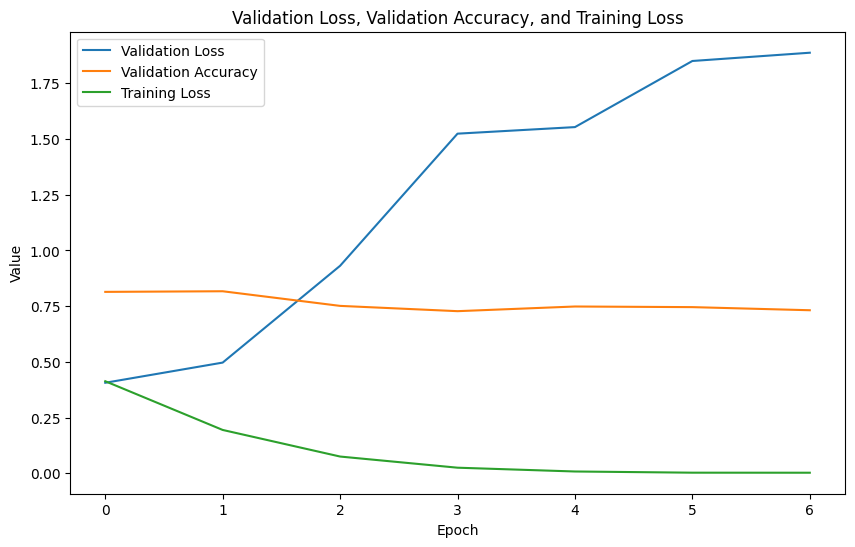

In [55]:
#plotting validation loss, validation accuracy, and training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(validation_losses, label='Validation Loss')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss, Validation Accuracy, and Training Loss')
plt.legend()
plt.show()

In [56]:
#testing the model
test_labels = torch.tensor(test_df['label'].values, dtype=torch.float32).unsqueeze(1)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#load most optimal model from training loop
lstm.load_state_dict(torch.load('model.pth'))
lstm.to(device)
lstm.eval()
preds = []
labels = []
with torch.no_grad():
  for batch_sequences, batch_labels in test_loader:
    batch_sequences = batch_sequences.to(device)

    logits = lstm(batch_sequences)
    probs = torch.sigmoid(logits)

    preds.extend((probs > 0.5).float().cpu().numpy())
    labels.extend(batch_labels.cpu().numpy())
test_accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")


Test Accuracy: 82.4017%


Before implementing early stopping, we saw that there was some overfitting happening in the training loop, giving test accuracy of around 80%. With this, we ended up with a higher accuracy close to 88%.

In [12]:
#printing classification report
print(classification_report(labels, preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.7670    0.9449    0.8467       526
         1.0     0.9088    0.6568    0.7625       440

    accuracy                         0.8137       966
   macro avg     0.8379    0.8008    0.8046       966
weighted avg     0.8316    0.8137    0.8084       966

